# Model Fit and Image Comparison Pipeline

The purpose of this notebook is to load a series of images fit blindly to data and compare the following metrics:

* Ring properties, such as

    * Radius
    * Width
    * Asymmetry
    * Intensity profiles along the ring
    * Flux inside the ring vs flux outside the ring
    * ...and more

Geometric properties, such as the radius, will be fit using a Hough transfrom and the `HoughTransform` library. Asymmetry, ring width, and flux inside and outside the ring will be determined using the `PontiFEX` library. 

These attributes are ring-specific. 


### 1. Load images.
Please provide your images and model fits as a .fits file, named as [naming convention]. For those submitting multiple images or model fits, please [multiple submission naming convention].

Note: proposed naming convention, will be used for now: `LastnameFirstname_YYMMDD_ID.fits`, where

 * `Lastname`, `Firstname` (self explanatory) ex: JohnsonMichael
 * `YYMMDD`, date of SUBMISSION (e.g. November 8th, 2018 becomes 181108)
 * `ID`, dataset ID unique to each challenge. For the first challenge, this tag is: `WCROMH`. See: https://docs.google.com/spreadsheets/d/11oCD7T6okr3iRfJjvlFesowY3O8QLhv87HbOpP79v3c/edit?usp=sharing
 
 Example submission file name: `JohnsonMichael_181108_WCROMH.fits`

In [1]:
## challenge ID, optional ##
CHALLENGE_ID = "SAMPLEDATA"

## add to path ##
import sys
sys.path.append('../../eht-mcp/')

## imports ##
import glob
import numpy
import datetime
import Pontifex
import itertools
import ehtim as eh
import seaborn as sns
import HoughTransform

## graph settings ##
import matplotlib.pyplot as plt
import matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rcParams["font.weight"] = "bold"
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
matplotlib.rcParams.update({'errorbar.capsize': 4})
cycol = itertools.cycle(sns.color_palette())

## ignore warnings ##
import warnings
warnings.filterwarnings('ignore')

## pdf import ##
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("results{0}.pdf".format(CHALLENGE_ID))

## settings ##
RUN_ALL = True
EXPORT_PDF = True

Welcome to eht-imaging v 1.1.0


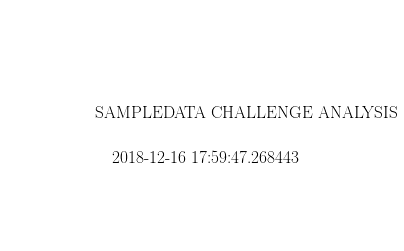

In [2]:
## quick class to store image submissions() and store the results of their analysis ##
class Submission(object):
    
    def __init__(self, _filepath, run_all_analyses=False):
        ## pre-analysis attributes ##
        print "Working on this file > ", _filepath
        self._filepath      = _filepath
        self.submitter      = self._filepath.split('/')[-1].split('_')[0]
        self.submissionDate = int(self._filepath.split('/')[-1].split('_')[1])
        self.challengeID    = self._filepath.split('/')[-1].split('_')[-1].split('.')[0]
        self.image          = self.loadImage(self._filepath)
        self.ImageAnalysisObject = Pontifex.AnalysisObject(self.image, intervals=15)
            
        
        ## post-analysis attributes ##
        self.analysisResults = {
            'radius':-1,
            'center':(0, 0),
            'width':-1,
            'asymmetry':-1,
            'fluxInside':-1,
            'fluxOutside':-1,
#             'fluxInRing':-1,
#             'fluxInDepression':-1,
#             'orientation':-1,
            'sharpness':-1
        }
        
        ## relevant units ## 
        self.metricUnits = {
            'radius':'uas',
            'center':'pixels',
            'width':'uas',
            'asymmetry':'ratio',
            'fluxInside':'\% total within ring',
            'fluxOutside':'\% total exterior to ring',
            'fluxInRing':'\% total',
            'fluxInDepression':'% total',
            'orientation':'angle',
            'sharpness':'ratio'
        }
        
        ## intensity profiles in the cardinal directions ##
        self.intensityProfiles = {
            0:self.ImageAnalysisObject.intensityProfiles[0],
            1:self.ImageAnalysisObject.intensityProfiles[1],
            2:self.ImageAnalysisObject.intensityProfiles[2],
            3:self.ImageAnalysisObject.intensityProfiles[3]
        }
        
        if run_all_analyses is True: self.runAll()
        
        
    def loadImage(self, _fp):
        return eh.image.load_image(_fp)

    def runAll(self):
        ## run all the analyses ##
        self.getRadius()
        self.getAsymmetry()
        self.getWidth()
        self.fluxInside()
        self.fluxOutside()
        self.sharpness()
    
    def getRadius(self):
        ## use PontiFEX to get the mean radius ##
        while 1:
            try:
                self.ImageAnalysisObject.iterative_peak_finding()
                break
            except ValueError:
                self.ImageAnalysisObject.iterative_peak_finding()
        self.analysisResults['radius'] = self.ImageAnalysisObject.get_radius_hough_transform()
        
    def getAsymmetry(self):
        ## use PontiFEX to get the asymmetry ##
        self.analysisResults['asymmetry'] = self.ImageAnalysisObject.get_asymmetry()
    
    def getWidth(self):
        ## use PontiFEX to get the mean width ##
        self.analysisResults['width'] = self.ImageAnalysisObject.get_mean_width()
    
    def fluxInside(self):
        ## use PontiFEX to get the flux inside the ring area ##
        self.analysisResults['fluxInside'] = self.ImageAnalysisObject.get_flux_inside_radius()
    
    def fluxOutside(self):
        ## use PontiFEX to get the flux outside the ring area ##
        self.analysisResults['fluxOutside'] = self.ImageAnalysisObject.get_flux_outside_radius()
    
    def plot_radius(self):
        self.ImageAnalysisObject.get_radius_CIRCUMCENTER_METHOD()
        plt.imshow(self.image.imvec.reshape((self.image.xdim, self.image.ydim)), interpolation='gaussian', cmap='gray')
        center = self.ImageAnalysisObject.centers['circumcenter']
        circle1 = plt.Circle(center,self.ImageAnalysisObject.uas_to_pix( self.ImageAnalysisObject.radius_dictionary['combined'] ),color='r', label='ring', fill=False)
        plt.gcf().gca().add_artist(circle1)
        
        plt.legend()
        plt.show()
        
    ## under construction ##
    def fluxInRing(self):
        ## use PontiFEX to get the flux in the ring ##
        print 'get the flux within the ring'
    
    def fluxInRingDepression(self):
        ## use PontiFEX to get the flux contained inside the ring but not part of the ring ##
        print 'get flux within ring depression'
    
    def orientation(self):
        ## get the orientation of the ring ##
        print 'get orientation'
    
    def sharpness(self):
        ## get the sharpness of the ring ##
        sharps = []
        for key in self.intensityProfiles:
            centerY = self.ImageAnalysisObject.centers['circumcenter'][1]
            centerRowSlice = self.intensityProfiles[key][:int(centerY)]
            sharps.append(Pontifex.FWHM(range(len(centerRowSlice)), centerRowSlice)/(2.2*numpy.max(centerRowSlice)))
        self.analysisResults['sharpness'] = numpy.median(sharps)

## general plotting functions ##
def twoMetricAllSubmissions(submissionsList, metric1='width', metric2='radius', save=False):
    metric1points = []
    metric2points = []
    labels = []
    for submission in submissionsList:
        metric1points.append(submission.analysisResults[metric1])
        metric2points.append(submission.analysisResults[metric2])
        labels.append(submission.submitter)
    
    fig, ax = plt.subplots()
    ax.scatter(metric1points, metric2points)
    plt.xlabel("{0} ({1})".format(metric1, submission.metricUnits[metric1]))
    plt.ylabel("{0} ({1})".format(metric2, submission.metricUnits[metric2]))
    plt.title("{0} vs {1}".format(metric1, metric2))

    for i, txt in enumerate(labels):
        ax.annotate(txt, (metric1points[i], metric2points[i]))
    
    if save:
        pdf.savefig(fig)

def plotTwoMetricAllSubmissions(submissionsList, show=False, save=False):
    for metric1 in sorted(submissionsList[0].analysisResults):
        for metric2 in sorted(submissionsList[0].analysisResults):
            print "Examining", metric1, metric2
            if metric1 == metric2 or metric1 == 'center' or metric2 == 'center': continue
            twoMetricAllSubmissions(submissionsList, metric1=metric1, metric2=metric2, save=save)
            if show:
                plt.show()
                
def oneMetricHist(submissionsList, metric='radius', show=False, save=False):
    if metric == 'center': return
    plt.xlabel("{0} ({1})".format(metric, submissionsList[0].metricUnits[metric]))
    plt.hist([submission.analysisResults[metric] for submission in submissionsList])
    if save:
        pdf.savefig()
    if show:
        plt.show()

def allMetricHist(submissionsList, show=False, save=False):
    for metric in sorted(submissionsList[0].analysisResults):
        oneMetricHist(submissionsList, metric=metric, show=show, save=save)

        
# plt.scatter()
plt.text(0.2, 0.5, CHALLENGE_ID + " CHALLENGE ANALYSIS", fontsize='xx-large')
plt.text(0.25, 0.3, str(datetime.datetime.now()), fontsize='xx-large')
plt.axis('off')
if EXPORT_PDF: pdf.savefig()

### 2. Create `Submission` object for each model/image.

A submission object allows us to calculate and memoize many different ring-related metrics for each model fit, which we can compare later. One of the biggest benefits is that you can use any metric extraction method you like (here we use `PontiFEX` and `Hyperion`), but you don't have to change any of the actual scripts, just the class. To use your own feature extraction metrics, have your function return a single quantity that can be added to the analysis dictionary `analysisResults`. 

In [3]:
%%capture 
## ^ uncomment when everything is working ##

## load images from folder ##
_imagesFilepath = './sample_images/'
imageFiles = sorted(glob.glob(_imagesFilepath + '*.fits'))
print imageFiles

## create a submission object for each image ##
submissionsList = [Submission(_file, run_all_analyses=RUN_ALL) for _file in imageFiles]
# if EXPORT_PDF: pdf.savefig()

### 3. Run analyses.

Once the features for each `Submission` have been extracted and memoized, perform any statistical analyses you like on them using the `Submission` object's `self.analysisResults` dict. Below are two examples of 

RAD 5.667133093709856
RAD 8.012153684210482
RAD 4.7938924148606565


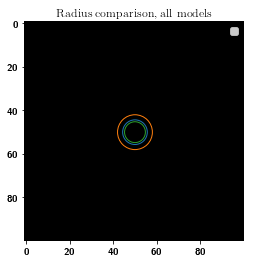

In [4]:
## visual analysis of radius ##
# potential TODO: make all circles centered?
plt.imshow(0*submissionsList[-1].image.imvec.reshape((submissionsList[-1].image.xdim, submissionsList[-1].image.ydim)), interpolation='gaussian', cmap='gray')
for submission in submissionsList:
#     submission.ImageAnalysisObject.get_radius_hough_transform()
    rad = submission.ImageAnalysisObject.radius_dictionary['hough']
    print "RAD", rad
    center = (submissionsList[-1].image.xdim/2, submissionsList[-1].image.xdim/2) #submission.ImageAnalysisObject.centers['circumcenter']
    circle1 = plt.Circle(center,rad, color=cycol.next(), fill=False)
    plt.gcf().gca().add_artist(circle1)

plt.legend()
plt.title("Radius comparison, all models")

if EXPORT_PDF: pdf.savefig()
plt.show()

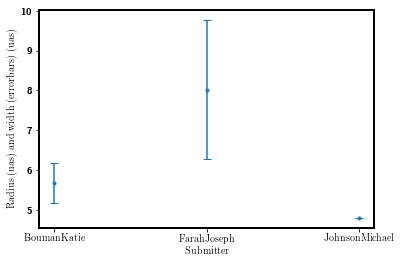

In [5]:
## creating plots of radius and mean width per submission ##
rads = []
widths = []
xticks = []
for submission in submissionsList:
    radius = submission.analysisResults['radius']
    width = submission.analysisResults['width']
    sID = submission.submitter
    rads.append(radius)
    widths.append(width / 2.)
    xticks.append(sID)

    
plt.errorbar(range(len(widths)), rads, yerr=widths, marker='.', linestyle='')
plt.xlabel("Submitter")
plt.ylabel("Radius (uas) and width (errorbars) (uas)")
plt.xticks(range(len(widths)), xticks)
if EXPORT_PDF:
    pdf.savefig()
plt.show()

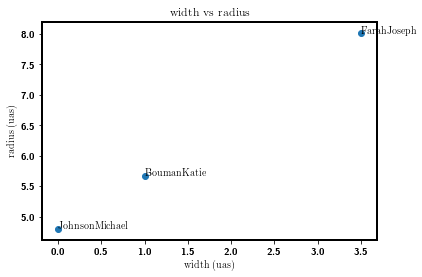

In [6]:
twoMetricAllSubmissions(submissionsList, metric1='width', metric2='radius', save=EXPORT_PDF)

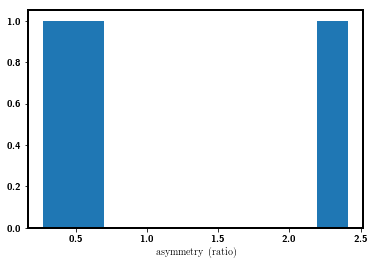

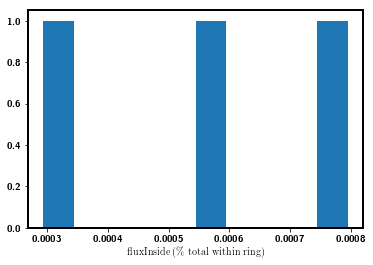

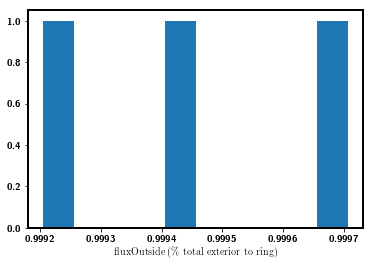

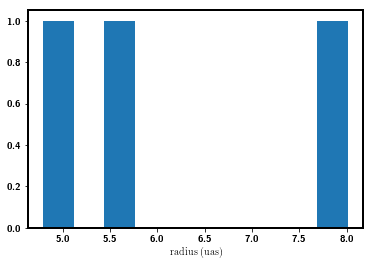

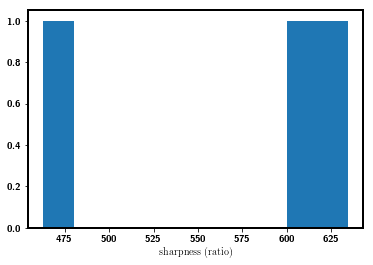

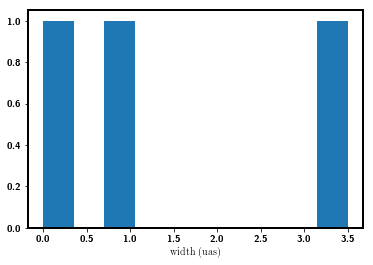

In [7]:
## plotting distributions of the parameters ##
allMetricHist(submissionsList, save=EXPORT_PDF, show=True)

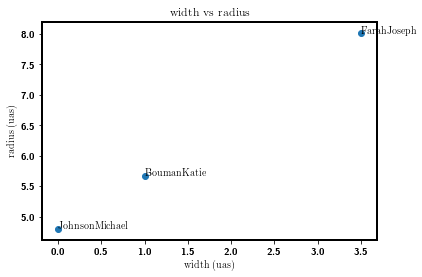

In [8]:
twoMetricAllSubmissions(submissionsList, save=EXPORT_PDF)

Examining asymmetry asymmetry
Examining asymmetry center
Examining asymmetry fluxInside


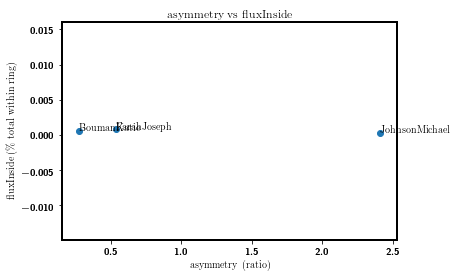

Examining asymmetry fluxOutside


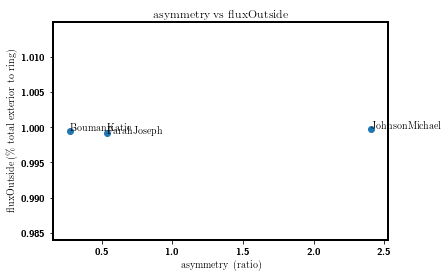

Examining asymmetry radius


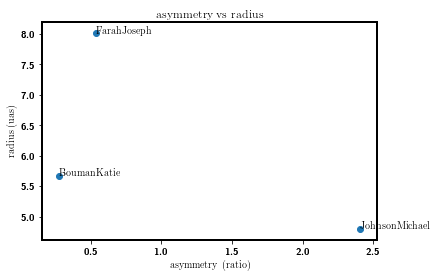

Examining asymmetry sharpness


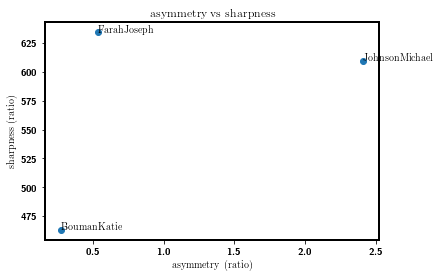

Examining asymmetry width


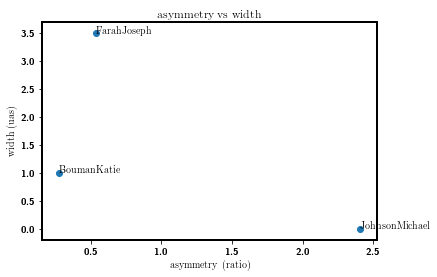

Examining center asymmetry
Examining center center
Examining center fluxInside
Examining center fluxOutside
Examining center radius
Examining center sharpness
Examining center width
Examining fluxInside asymmetry


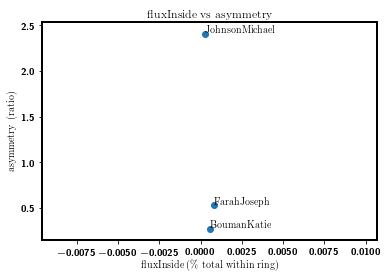

Examining fluxInside center
Examining fluxInside fluxInside
Examining fluxInside fluxOutside


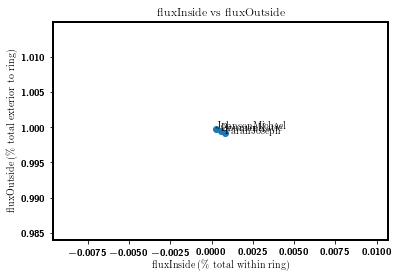

Examining fluxInside radius


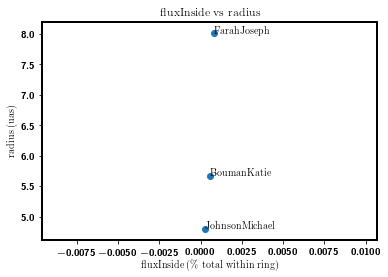

Examining fluxInside sharpness


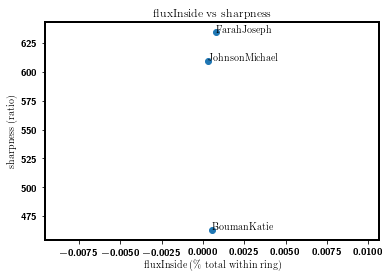

Examining fluxInside width


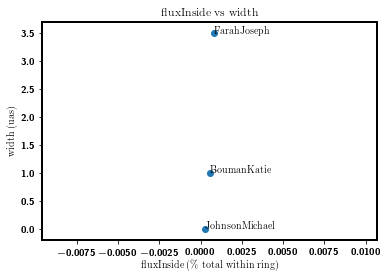

Examining fluxOutside asymmetry


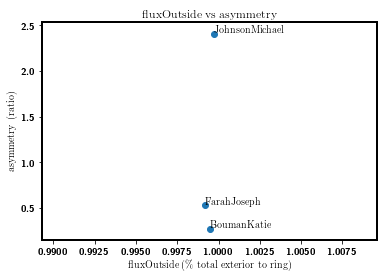

Examining fluxOutside center
Examining fluxOutside fluxInside


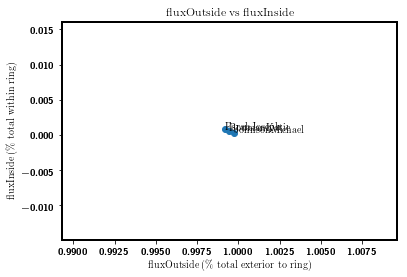

Examining fluxOutside fluxOutside
Examining fluxOutside radius


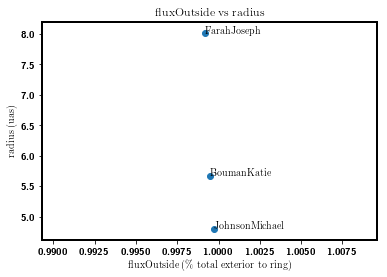

Examining fluxOutside sharpness


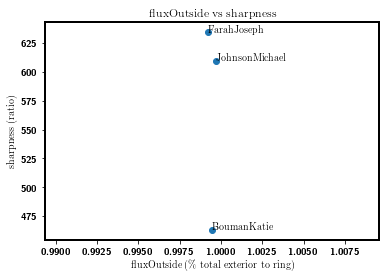

Examining fluxOutside width


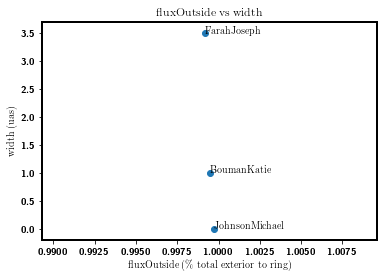

Examining radius asymmetry


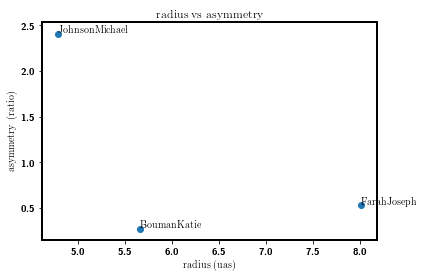

Examining radius center
Examining radius fluxInside


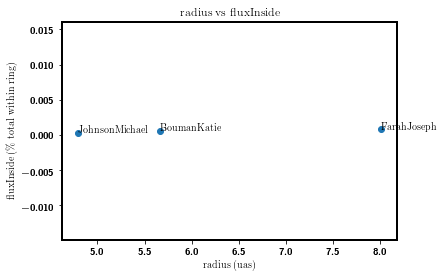

Examining radius fluxOutside


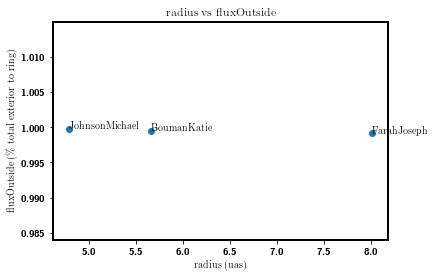

Examining radius radius
Examining radius sharpness


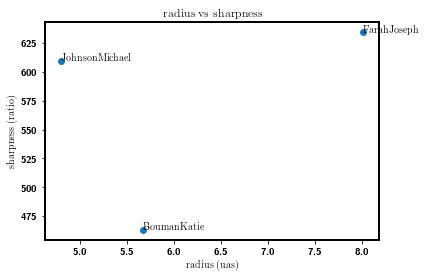

Examining radius width


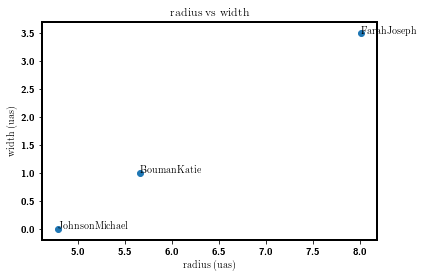

Examining sharpness asymmetry


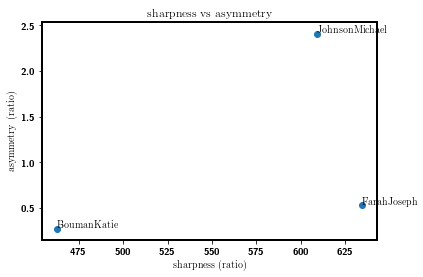

Examining sharpness center
Examining sharpness fluxInside


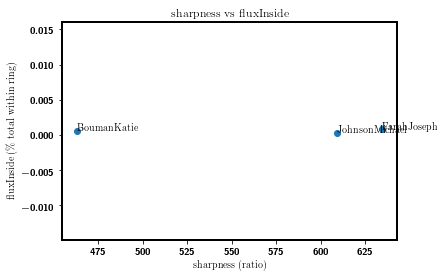

Examining sharpness fluxOutside


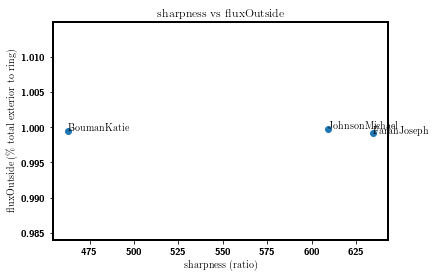

Examining sharpness radius


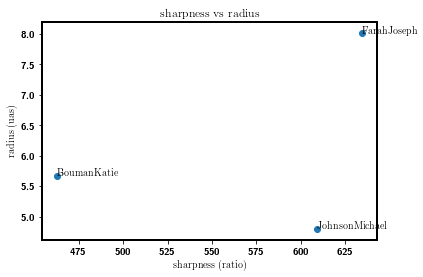

Examining sharpness sharpness
Examining sharpness width


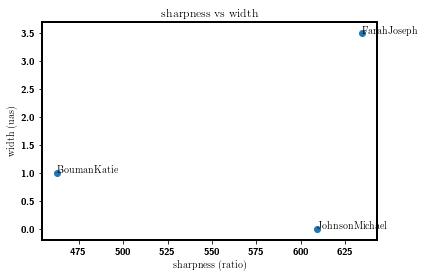

Examining width asymmetry


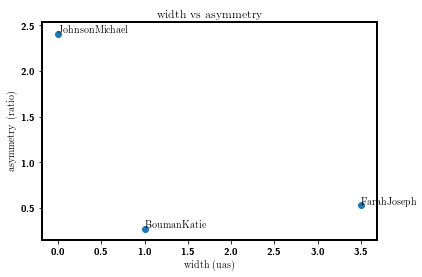

Examining width center
Examining width fluxInside


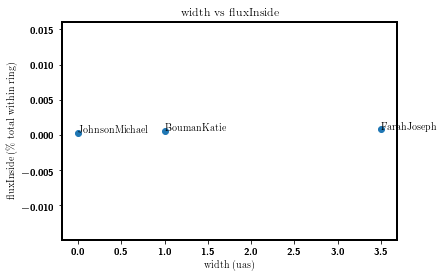

Examining width fluxOutside


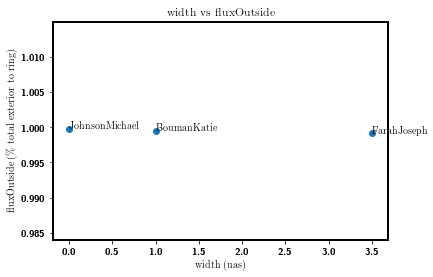

Examining width radius


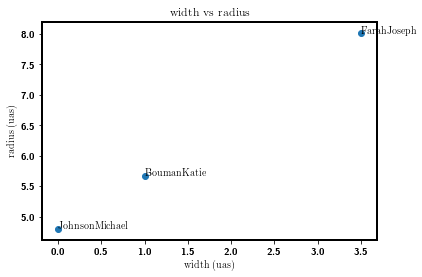

Examining width sharpness


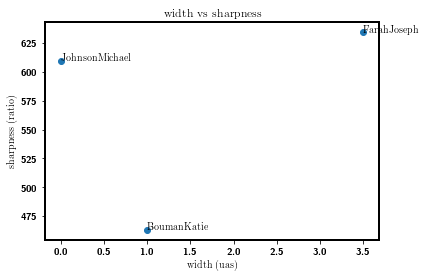

Examining width width


In [9]:
plotTwoMetricAllSubmissions(submissionsList, show=EXPORT_PDF, save=True)

In [10]:
pdf.close()